In [10]:
from fastai.vision.all import *
from py_files.ensemble import ensemble_np, ensemble, ranks_np
from sklearn.metrics import confusion_matrix, classification_report
from patchify import patchify
from tqdm.notebook import tqdm
import skfuzzy as sk

In [2]:
file_path = '...\\Training\\'

In [3]:
def get_dls():
    dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                      get_items=get_image_files,
                      item_tfms=Resize(64), 
                      get_y=parent_label, 
                      splitter=RandomSplitter(seed=0))
    return dblock.dataloaders(file_path, bs=8, num_workers=0)

In [4]:
dls = get_dls()

In [5]:
learn1 = load_learner('...\\resnet.pkl')
learn2 = load_learner('...\\densenet.pkl')
learn3 = load_learner('...\\vgg.pkl')
learn4 = load_learner('...\\mobile.pkl')
learn5 = load_learner('...\\efficientnet.pkl')
learn6 = load_learner('...\\squeeze.pkl')

In [6]:
pred1, targ1 = learn1.get_preds(dl=learn1.dls.test_dl(dls.valid.items, with_labels=True))
pred2, targ2 = learn2.get_preds(dl=learn2.dls.test_dl(dls.valid.items, with_labels=True))
pred3, targ3 = learn3.get_preds(dl=learn3.dls.test_dl(dls.valid.items, with_labels=True))
pred4, targ4 = learn4.get_preds(dl=learn4.dls.test_dl(dls.valid.items, with_labels=True))
pred5, targ5 = learn5.get_preds(dl=learn5.dls.test_dl(dls.valid.items, with_labels=True))
pred6, targ6 = learn6.get_preds(dl=learn6.dls.test_dl(dls.valid.items, with_labels=True))

In [7]:
f1 = CohenKappa()
f2 = F1Score(average='macro')

In [8]:
acc_list = [accuracy(pred1, targ1, ), accuracy(pred2, targ1), accuracy(pred3, targ1),
            accuracy(pred4, targ1), accuracy(pred5, targ1), accuracy(pred6, targ1)]
acc_list

[TensorBase(0.9140),
 TensorBase(0.9554),
 TensorBase(0.9236),
 TensorBase(0.8185),
 TensorBase(0.7102),
 TensorBase(0.9459)]

In [9]:
p = [pred1, pred2, pred3, pred4, pred5, pred6]
a = acc_list
en = ensemble_np(p, a, alpha=1)

en = torch.from_numpy(en)

100%|███████████████████████████████████████████████████████████████████████████████| 314/314 [00:00<00:00, 402.95it/s]


In [15]:
rnk = ranks_np(pred1)
np.unique(rnk[0]), pred1[0], pred2[0]

(array([0.50003517, 0.5000784 , 0.5001993 , 0.5003258 , 0.5004522 ,
        0.50108194, 0.50780445, 0.5086478 , 0.87274987], dtype=float32),
 TensorBase([3.9861e-04, 6.5162e-04, 1.5675e-04, 2.1639e-03, 9.0440e-04,
             7.0358e-05, 1.7297e-02, 9.6275e-01, 1.5610e-02]),
 TensorBase([3.0519e-06, 2.9535e-07, 5.2097e-06, 1.7844e-06, 3.0253e-06,
             1.4565e-06, 1.0393e-05, 9.9996e-01, 1.2641e-05]))

In [11]:
accuracy(en, targ1)

TensorBase(0.9713)

In [12]:
#def print_rep(x):
#    with pd.ExcelWriter('E:\\Codes\\Notebooks_pyfiles\\Files\\class_rep_new.xlsx') as writer:  
#        for i, j in zip(x, ['Resnet', 'Desnet', 'Vgg', 'Mobile', 'Efficient', 'Squeeze', 'Proposed']):
#            a = classification_report(targ1, i.argmax(dim=1).numpy(), target_names=list(dls.vocab), output_dict=True)
#            p = pd.DataFrame(a)
#            p = p.transpose()
#            p.to_excel(writer, sheet_name=j)
    

In [13]:
#p.append(en)

In [14]:
#print_rep(p)

In [15]:
confusion_matrix(targ1, en.argmax(dim=1))

array([[28,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 31,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 30,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 35,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  2, 17,  0,  0,  0,  0],
       [ 0,  0,  1,  1,  0, 41,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0, 67,  2,  1],
       [ 0,  1,  0,  0,  0,  0,  0, 18,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  1, 38]], dtype=int64)

In [16]:
confusion_matrix(targ1, pred5.argmax(dim=1))

array([[26,  0,  0,  0,  0,  1,  0,  1,  0],
       [ 0, 19,  2,  1,  0,  1,  5,  2,  1],
       [ 0,  0, 21,  1,  0,  5,  2,  1,  0],
       [ 0,  1,  0, 24,  0,  2,  2,  5,  1],
       [ 0,  1,  0,  1, 11,  6,  0,  0,  0],
       [ 0,  1,  1,  1,  0, 39,  0,  0,  1],
       [ 0,  9,  0,  0,  0,  0, 52,  4,  5],
       [ 0,  0,  0,  2,  0,  2,  2, 12,  1],
       [ 0,  2,  1,  4,  1,  3,  5,  4, 19]], dtype=int64)

In [17]:
a = classification_report(targ1, pred1.argmax(dim=1).numpy(), target_names=list(dls.vocab), output_dict=True)

In [18]:
stacked = np.stack([pred1.numpy(), pred2.numpy(), pred3.numpy(), 
                 pred4.numpy(), pred5.numpy(), pred6.numpy()])

maxi = np.max(stacked, axis=0)
a = classification_report(targ1, np.argmax(maxi, axis=1), target_names=list(dls.vocab), output_dict=True)
aa =  pd.DataFrame(a)
aa.transpose()

,precision,recall,f1-score,support
(g)M,1.000000,1.000000,1.000000,28.000000
(g)S,0.968750,1.000000,0.984127,31.000000
(g)mS,0.935484,0.966667,0.950820,30.000000
M,0.897436,1.000000,0.945946,35.000000
S,1.000000,0.894737,0.944444,19.000000
gM,1.000000,0.930233,0.963855,43.000000
gS,1.000000,0.971429,0.985507,70.000000
gmS,0.900000,0.947368,0.923077,19.000000
mS,1.000000,1.000000,1.000000,39.000000
accuracy,0.971338,0.971338,0.971338,0.971338


In [19]:
print(f'Kappa, {f1(torch.from_numpy(maxi).argmax(axis=1), targ1)}')
print(f'F1, {f2(torch.from_numpy(maxi).argmax(axis=1), targ1)}')

Kappa, 0.9670709966092215
F1, 0.9664196264210005


In [20]:
stacked.shape

(6, 314, 9)

In [21]:
summ = np.sum(stacked, axis=0)
a = classification_report(targ1, np.argmax(summ, axis=1), target_names=list(dls.vocab), output_dict=True)
aa =  pd.DataFrame(a)
aa.transpose()

,precision,recall,f1-score,support
(g)M,1.000000,1.000000,1.000000,28.000000
(g)S,0.968750,1.000000,0.984127,31.000000
(g)mS,0.967742,1.000000,0.983607,30.000000
M,0.921053,1.000000,0.958904,35.000000
S,1.000000,0.894737,0.944444,19.000000
gM,1.000000,0.953488,0.976190,43.000000
gS,0.985507,0.971429,0.978417,70.000000
gmS,0.857143,0.947368,0.900000,19.000000
mS,1.000000,0.948718,0.973684,39.000000
accuracy,0.971338,0.971338,0.971338,0.971338


In [22]:
print(f'Kappa, {f1(torch.from_numpy(summ).argmax(axis=1), targ1)}')
print(f'F1, {f2(torch.from_numpy(summ).argmax(axis=1), targ1)}')

Kappa, 0.9670637048087457
F1, 0.9665971164934845


In [23]:
prd = np.prod(stacked, axis=0)
a = classification_report(targ1, np.argmax(prd, axis=1), target_names=list(dls.vocab), output_dict=True)
aa =  pd.DataFrame(a)
aa.transpose()

,precision,recall,f1-score,support
(g)M,1.000000,1.000000,1.000000,28.000000
(g)S,0.968750,1.000000,0.984127,31.000000
(g)mS,0.967742,1.000000,0.983607,30.000000
M,0.945946,1.000000,0.972222,35.000000
S,1.000000,0.947368,0.972973,19.000000
gM,1.000000,0.953488,0.976190,43.000000
gS,1.000000,0.971429,0.985507,70.000000
gmS,0.857143,0.947368,0.900000,19.000000
mS,1.000000,0.974359,0.987013,39.000000
accuracy,0.977707,0.977707,0.977707,0.977707


In [24]:
print(f'Kappa, {f1(torch.from_numpy(prd).argmax(axis=1), targ1)}')
print(f'F1, {f2(torch.from_numpy(prd).argmax(axis=1), targ1)}')

Kappa, 0.9743969061957624
F1, 0.9735154940310559


In [25]:
full = '...\\full_image.png'

test_data = PILImage.create(full)

<AxesSubplot:>

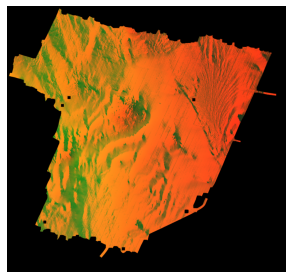

In [26]:
test_data.show()

In [27]:
patch = patchify(np.array(test_data), (32, 32, 3), step=1)
patches = patch
patches = torch.from_numpy(patches).squeeze(2)
patches.shape

torch.Size([2860, 3006, 32, 32, 3])

In [28]:
def k(x):
    i = sk.sigmf(x, 0, -2)
    y = sk.sigmf(x, 0, 2)
    return np.maximum(i, y) #i + y - (i * y)

def ranks_np (x):    
    i = np.apply_along_axis(k, axis=1, arr=x)    
    return i #fuzzy ranks

def ensemble_(probs, acc, alpha=2): 
    fuse_score = np.empty(probs[0].shape) #empty tensor of size row x column as prediction size
    total_acc = sum(acc) #sum of all accuracies

    rank = [ranks_np(prob) for prob in probs]
    for i in range(fuse_score.shape[0]):
        vals = [] #empty set to hold a list of 1d tensor values
        assert len(probs) == len(acc), f'Length(model predictions): {len(probs)} is not equal to Length(accuracies): {len(acc)}'
        for value in zip(rank, acc):
            cal = np.power((value[1] / total_acc) * (value[0][i] - 0.5), alpha) #calc values for rank rows using the accuracy
            vals.append(cal)
        sum_ = sum(vals) #sum all values for 
        pr = 0.5 + np.power(sum_, 1 / alpha) #
        fuse_score[i: ] = pr
    return fuse_score


In [29]:
def predictions(lrn, pat):
    pred = []

    with lrn[0].no_bar():
     with lrn[1].no_bar():
      with lrn[2].no_bar():
       with lrn[3].no_bar():
        with lrn[4].no_bar():
         with lrn[5].no_bar():   
           for count, i in tqdm(enumerate(range(pat.shape[0])), total=pat.shape[0]):
            patches_a = pat[i, :, :, :, :]
            
            test_dl1 = lrn[0].dls.test_dl(patches_a, bs=500)
            test_dl2 = lrn[1].dls.test_dl(patches_a, bs=500)
            test_dl3 = lrn[2].dls.test_dl(patches_a, bs=500)
            test_dl4 = lrn[3].dls.test_dl(patches_a, bs=500)
            test_dl5 = lrn[4].dls.test_dl(patches_a, bs=500)
            test_dl6 = lrn[5].dls.test_dl(patches_a, bs=500)
            
            preds1, _ = lrn[0].get_preds(dl=test_dl1)
            preds2, _ = lrn[1].get_preds(dl=test_dl2)
            preds3, _ = lrn[2].get_preds(dl=test_dl3)
            preds4, _ = lrn[3].get_preds(dl=test_dl4)
            preds5, _ = lrn[4].get_preds(dl=test_dl5)
            preds6, _ = lrn[5].get_preds(dl=test_dl6)

            p = [preds1, preds2, preds3, preds4, preds5, preds6]
            acc_list = [0.9140, 0.9554, 0.9236, 0.8185, 0.7102, 0.9459]
            en = ensemble_(p, acc_list, alpha=1)
            en = np.argmax(en, axis=1)

     

    return np.array(pred)

In [ ]:
plt.imshow(pp)

In [ ]:
PILImage.save(PILImage.create(pp.astype(np.uint8)), 'E:\\Multiclassifier\\inf_images\\proposed.png', dpi=(300, 300))
tiff.imwrite('E:\\Multiclassifier\\inf_images\\proposed.tif', pp.astype(np.float32))